# Test

## scenarios

In [1]:
from real_map import RealMap, RealDataMap
from demands import DemandGenerator
from order_info import OrderGenerator
from instance import PDPTWInstance
from solvers import greedy_insertion_init, ALNS
import random
import numpy as np
import pandas as pd

In [ ]:
 # Set random seed
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)

# Create RealMap instance
realMap = RealMap(n_r=2, n_c=4, dist_function=np.random.uniform, dist_params={'low': -1, 'high': 1})

# Generate demands
random_params = {
    'sample_dist': {'function': np.random.randint, 'params': {'low': 1, 'high': 3}},
    'demand_dist': {'function': np.random.poisson, 'params': {'lam': 2}}
    }
demands = DemandGenerator(time_range=30, time_step=10, restaurants=realMap.restaurants,
                         customers=realMap.customers, random_params=random_params)

# Create PDPTWInstance
time_params = {'time_window_length': 30, 'service_time': 5, 'extra_time': 10}
pdptw_order = OrderGenerator(realMap, demands.demand_table, time_params, robot_speed=4)

# Generate and display the whole table
df = pdptw_order.order_table
print('Total number of orders:', pdptw_order.total_number_orders)
pd.set_option('display.max_columns', None)
df

In [ ]:
from real_map import RealDataMap

node_info_file = 'purdue_node_info.csv'
tt_matrix = 'tt_matrix.csv'
real_data_map = RealDataMap(node_info_file, tt_matrix)
print(f"Number of restaurants: {real_data_map.N_R}")
print(f"Number of customers: {real_data_map.N_C}")
print(f"Total number of nodes: {len(real_data_map.all_nodes)}")
print(f"Number of customer nodes: {len(real_data_map.customers)}")
print(f"Depot index: {real_data_map.DEPOT_INDEX}")
print(f"Depot info: {real_data_map.node_data.loc[real_data_map.DEPOT_INDEX].to_dict()}")
    
# 使用默认参数绘图
real_data_map.plot_map()
    
# # 使用自定义参数绘图
# real_data_map.plot_map(
#     show_index=False,
#     show_legend=True,
#     figsize=(20, 20),
#     node_size=100,
#     font_size=10,
#     highlight_depot=True
# )

## solution

In [ ]:
# Solution
def battery_relaxation(battery, dist_matrix, robot_speed, indicator = None):
    if indicator:
        battery_capacity = (battery - np.mean(dist_matrix[0][1:-1]))*2/robot_speed*60
    else:
        battery_capacity = battery/robot_speed*60
    return battery_capacity


def generate_d_matrix(instance):
    n = instance.n
    robot_speed = instance.robot_speed
    dist_matrix = instance.distance_matrix
    start_time = np.array([instance.time_windows[i][0] for i in range(1, n+1)])
    end_time = np.array([instance.time_windows[i][1] for i in range(1, n+1)])
    
    d_matrix = np.zeros((n, n))
    for i in range(n):
            for j in range(n):
                # pickup-pickup
                d_1 = dist_matrix[i+1][j+1]
                t_1 = abs(start_time[i] - start_time[j]) / 60 * robot_speed 
                dt_1 = d_1 + t_1 * 0.3

                # pickup-dropoff
                d_2 = dist_matrix[i+1][j+n+1]
                t_2 = abs(start_time[i] - end_time[j]) / 60 * robot_speed 
                dt_2 = d_2 + t_2 * 0.3

                # dropoff-pickup
                d_3 = dist_matrix[i+n+1][j+1]
                t_3 = abs(start_time[j] - end_time[i]) / 60 * robot_speed 
                dt_3 = d_3 + t_3 * 0.3

                # dropoff-dropoff
                d_4 = dist_matrix[i+n+1][j+n+1]
                t_4 = abs(start_time[j] - end_time[i]) / 60 * robot_speed 
                dt_4 = d_4 + t_4 * 0.3

                d_matrix[i][j] = min(dt_1, dt_2, dt_3, dt_4)

    return d_matrix



num_vehicles = 4
vehicle_capacity = 6
battery_consume_rate = 1
penalty_unvisited = 100
penalty_delayed = 15

battery = 8
dist_matrix = pdptw_instance.distance_matrix
robot_speed = pdptw_instance.robot_speed
if_battery_relaxation = 1
battery_capacity = battery_relaxation(battery, dist_matrix, robot_speed, if_battery_relaxation)


# 使用贪心插入法生成初始解
initial_solution = greedy_insertion_init(pdptw_instance, num_vehicles, vehicle_capacity, 
                                         battery_capacity, battery_consume_rate, 
                                         penalty_unvisited, penalty_delayed)

print("Initial solution objective value:", initial_solution.objective_function())



d_matrix = generate_d_matrix(pdptw_instance)
params_operators = {
        'num_removal': int(pdptw_instance.n*0.3),
        'p': 3,
        'k': 3,
        'L_max': 6,
        'avg_remove_order': 6,
        'd_matrix': d_matrix 
    }

max_no_improve = 25
segment_length = 10
num_segments = 15
r = 0.2 # update the weights
sigma = [10, 5, 1]
start_temp = 100
cooling_rate = 0.99

alns = ALNS(
    initial_solution=initial_solution,
    params_operators=params_operators,
    dist_matrix = dist_matrix,
    battery = battery,
    max_no_improve=max_no_improve,
    segment_length=segment_length,
    num_segments=num_segments,
    r=r,
    sigma=sigma,
    start_temp=start_temp,
    cooling_rate=cooling_rate
    )

In [ ]:
initial_solution.plot_solution()

# Sensitivity analysis

## 导入包

In [8]:
from real_map import RealMap, RealDataMap
from demands import DemandGenerator
from order_info import OrderGenerator
from instance import PDPTWInstance
from solvers import greedy_insertion_init, ALNS
import random
import numpy as np
import pandas as pd

## Scenario

In [9]:
# ==================  Random seed ==============================
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)

# ==================  Real data map ==========================
node_info_file = 'data/purdue_node_info.csv'
tt_matrix = 'data/tt_matrix.csv'
real_data_map = RealDataMap(node_info_file, tt_matrix)

# ==================  Demands ==========================
n_r = real_data_map.N_R
n_c = real_data_map.N_C
n_pairs = n_r*n_c # total number of restranuts-customer pairs
time_range=30
time_step=10
n_time_intervals = time_range / time_step
average_order = 10
lam_poisson = average_order/(n_pairs*n_time_intervals)

random_params = {
    'sample_dist': {'function': np.random.randint, 'params': {'low': n_pairs-0.5, 'high': n_pairs}},
    'demand_dist': {'function': np.random.poisson, 'params': {'lam': lam_poisson  }}
    }

restaurants=real_data_map.restaurants
customers=real_data_map.customers
## Create demands
demands = DemandGenerator(time_range, time_step, restaurants, customers, random_params=random_params)\
    
# ========================== Order ==========================
time_params = {'time_window_length': 30, 
               'service_time': 2, 
               'extra_time': 0,
               'big_time': 1000}
robot_speed = 4 # mph
## Create Order info
pdptw_order = OrderGenerator(real_data_map, demands.demand_table, time_params, robot_speed)

# ========================== Instace ========================== 
pdptw_instance = PDPTWInstance(pdptw_order)

## Solution

In [12]:
# Solution
def battery_relaxation(battery, dist_matrix, robot_speed, indicator = None):
    if indicator:
        battery_capacity = (battery - np.mean(dist_matrix[0][1:-1]))*2/robot_speed*60
    else:
        battery_capacity = battery/robot_speed*60
    return battery_capacity


def generate_d_matrix(instance):
    n = instance.n
    robot_speed = instance.robot_speed
    dist_matrix = instance.distance_matrix
    start_time = np.array([instance.time_windows[i][0] for i in range(1, n+1)])
    end_time = np.array([instance.time_windows[i][1] for i in range(1, n+1)])
    
    d_matrix = np.zeros((n, n))
    for i in range(n):
            for j in range(n):
                # pickup-pickup
                d_1 = dist_matrix[i+1][j+1]
                t_1 = abs(start_time[i] - start_time[j]) / 60 * robot_speed 
                dt_1 = d_1 + t_1 * 0.3

                # pickup-dropoff
                d_2 = dist_matrix[i+1][j+n+1]
                t_2 = abs(start_time[i] - end_time[j]) / 60 * robot_speed 
                dt_2 = d_2 + t_2 * 0.3

                # dropoff-pickup
                d_3 = dist_matrix[i+n+1][j+1]
                t_3 = abs(start_time[j] - end_time[i]) / 60 * robot_speed 
                dt_3 = d_3 + t_3 * 0.3

                # dropoff-dropoff
                d_4 = dist_matrix[i+n+1][j+n+1]
                t_4 = abs(start_time[j] - end_time[i]) / 60 * robot_speed 
                dt_4 = d_4 + t_4 * 0.3

                d_matrix[i][j] = min(dt_1, dt_2, dt_3, dt_4)

    return d_matrix

num_vehicles = 4
vehicle_capacity = 6
battery_consume_rate = 1
penalty_unvisited = 100
penalty_delayed = 5

battery = 8 # mile
dist_matrix = pdptw_instance.distance_matrix
robot_speed = pdptw_instance.robot_speed
if_battery_relaxation = 1
battery_capacity = battery_relaxation(battery, dist_matrix, robot_speed, if_battery_relaxation)


# 使用贪心插入法生成初始解
initial_solution = greedy_insertion_init(pdptw_instance, num_vehicles, vehicle_capacity, 
                                         battery_capacity, battery_consume_rate, 
                                         penalty_unvisited, penalty_delayed)

print("Initial solution objective value:", initial_solution.objective_function())



d_matrix = generate_d_matrix(pdptw_instance)
params_operators = {
        'num_removal': int(pdptw_instance.n*0.3),
        'p': 3,
        'k': 3,
        'L_max': 6,
        'avg_remove_order': 6,
        'd_matrix': d_matrix 
    }

max_no_improve = 25
segment_length = 10
num_segments = 15
r = 0.2 # update the weights
sigma = [10, 5, 1]
start_temp = 100
cooling_rate = 0.99

alns = ALNS(
    initial_solution=initial_solution,
    params_operators=params_operators,
    dist_matrix = dist_matrix,
    battery = battery,
    max_no_improve=max_no_improve,
    segment_length=segment_length,
    num_segments=num_segments,
    r=r,
    sigma=sigma,
    start_temp=start_temp,
    cooling_rate=cooling_rate
    )

Initial solution objective value: 13.903109349174196


In [14]:
best_solution, best_charging_solution = alns.run()

Segment 1 / 15
3.314292815688419 100 inf 100
Segment 1 completed in 0.09 seconds
Segment 2 / 15
3.314292815688419 100 3.314292815688419 100
Segment 2 completed in 0.07 seconds
Segment 3 / 15
3.314292815688419 100 3.314292815688419 100
Segment 3 completed in 0.08 seconds
Segment 4 / 15
2.9646594256030427 100 2.9646594256030427 0.23563547789777184
Segment 4 completed in 0.07 seconds
Segment 5 / 15
2.482490959026682 100 2.482490959026682 0.5234124050853146
Segment 5 completed in 0.08 seconds
Segment 6 / 15
2.482490959026682 100 2.482490959026682 0.2347628965911488
Segment 6 completed in 0.08 seconds
Segment 7 / 15
2.482490959026682 100 2.482490959026682 0.04588668646774474
Segment 7 completed in 0.11 seconds
Segment 8 / 15
2.482490959026682 100 2.482490959026682 0.0
Segment 8 completed in 0.10 seconds
ALNS run completed in 0.67 seconds


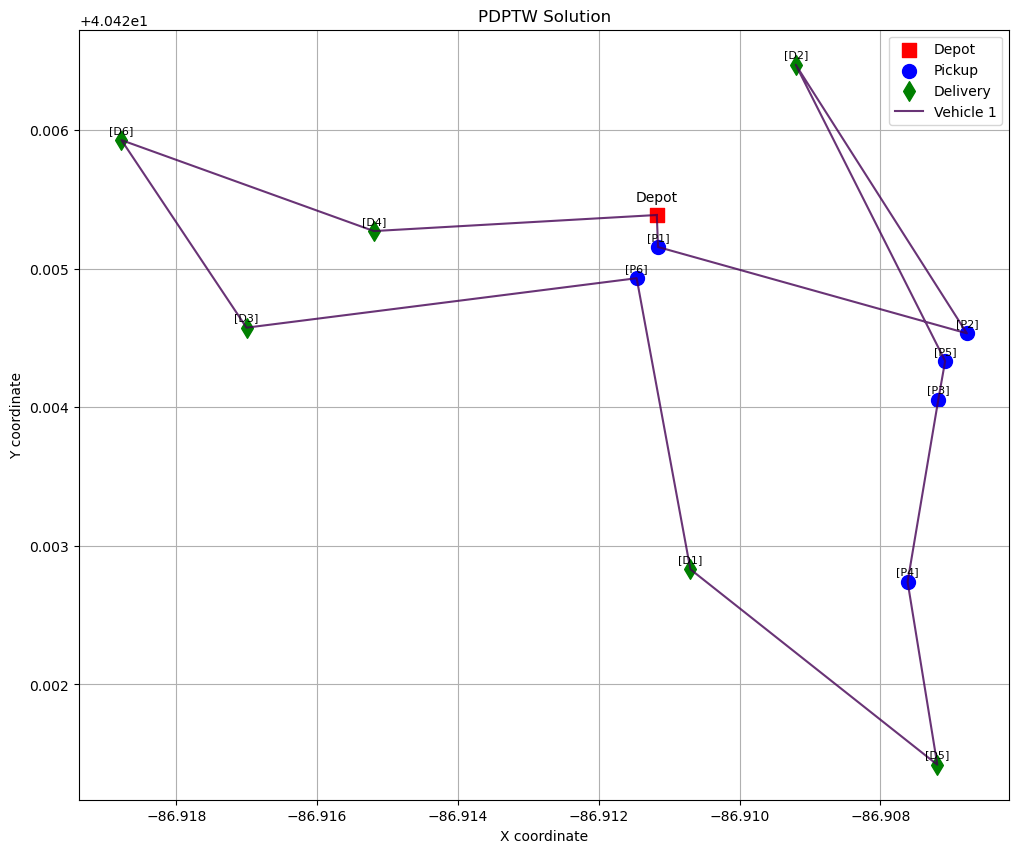

In [15]:
best_solution.plot_solution()

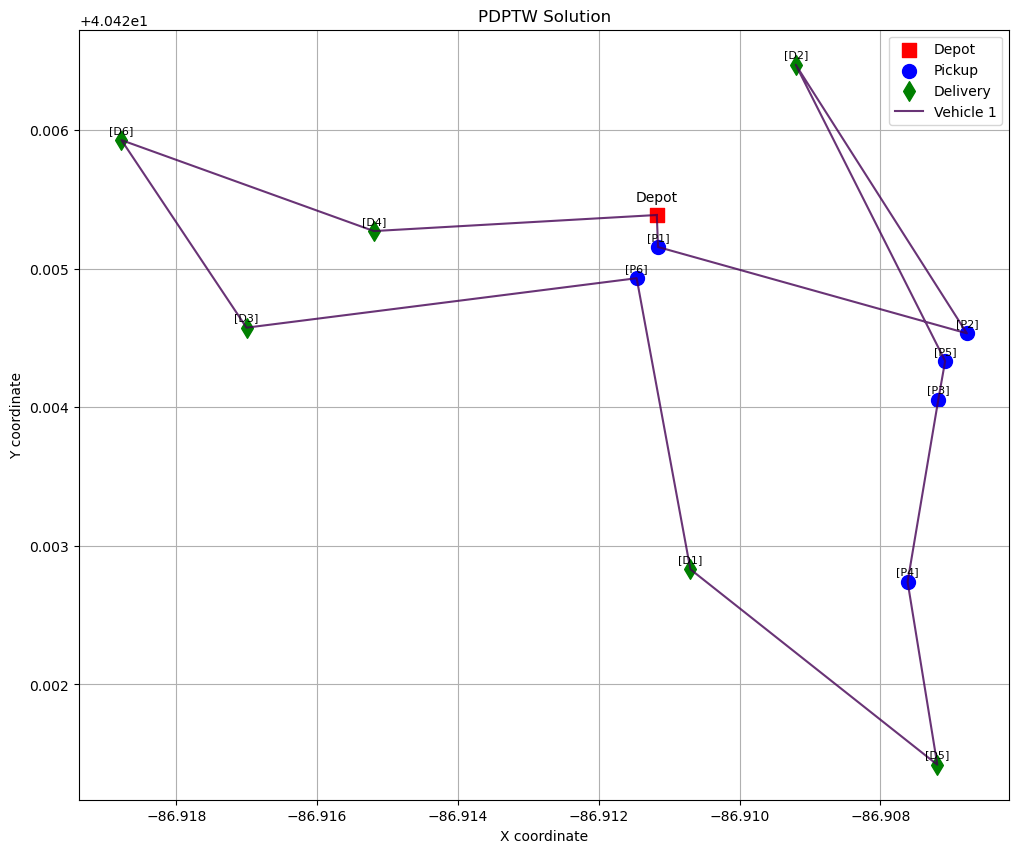

In [16]:
best_charging_solution.plot_solution()